<a href="https://colab.research.google.com/github/maxiuboldi/challenge_ml/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science Challenge Mercado Libre - BI Team

## Instalar dependencias

In [1]:
!pip install cherrypicker

## Importar librerias

In [2]:
import urllib.request
import urllib.parse
import json
import pandas as pd
import numpy as np
from math import ceil
from cherrypicker import CherryPicker
from time import sleep
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score
import seaborn as sns 
import matplotlib.pyplot as plt

## Contantes

In [3]:
# API ML
URL_CATEGORIES = 'https://api.mercadolibre.com/sites/MLA/categories'
URL_CHILD_CATEGORIES = 'https://api.mercadolibre.com/categories/'
URL_SEARCH = 'https://api.mercadolibre.com/sites/MLA/search?'
LIMIT_CALLS = 1050 / 50
SLEEP = 0  # No encontré en la documentación límites, pero por las dudas...

# Modelo
SEED = 8888
K_FOLD = 10
TEST_SIZE = 0.20

# Opciones de Pandas
pd_options = {
'display.max_rows': None,
'display.max_columns': None,
'display.width': None,
'display.float_format': '{:.2f}'.format
}
[pd.set_option(option, setting) for option, setting in pd_options.items()]

# Otras opciones
plt.rcParams['figure.figsize'] = (24, 12)
sns.set()

## Descarga de categorías

In [4]:
print('Descargando categorías {}\n'.format(URL_CATEGORIES))
with urllib.request.urlopen(URL_CATEGORIES) as handler:
    categories = json.loads(handler.read())
sleep(SLEEP)

categories_list = []
for category in categories:
    url_categorie = URL_CHILD_CATEGORIES + category.get('id')
    print('Descargando sub categorías {}'.format(url_categorie))
    with urllib.request.urlopen(url_categorie) as handler:
        category_detail = json.loads(handler.read())
        for detalle in category_detail.get('children_categories'):
            categories_list.append(detalle)
    sleep(SLEEP)

categories_df = pd.DataFrame(categories_list)
categories_df.set_index('id', inplace=True)

print('\nListo')

Descargando categorías https://api.mercadolibre.com/sites/MLA/categories

Descargando sub categorías https://api.mercadolibre.com/categories/MLA5725
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1512
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1403
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1071
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1367
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1368
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1743
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1384
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1246
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1039
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1051
Descargando sub categorías https://api.mercadolibre.com/categories/MLA1648
Descargando sub categorías

## Muestreo de categorías adicionales y descarga de datos

In [5]:
print('\nMuestreando categorías')
categories_search_dict = categories_df[~categories_df['name'].str.lower().str.contains(
    r'tvs|smartphones')]['name'].sample(8, random_state=8888).to_dict()
categories_search_dict.update(categories_df[categories_df['name'].str.lower().str.contains(r'tvs|smartphones')]['name'])

print('Categorías seleccionadas')
for category, name in categories_search_dict.items():
    print(category, ': ', name)

print('Descargando resultados de búsqueda\n')
results_list = []
for category, name in categories_search_dict.items():
    print('Procesando categoría {}\n'.format(category))
    current_call = 0
    # La API sólo permite pasar un offset hasta 1.000, que devuelve un máximo de 1.050 artículos
    # con un máximo de 21 llamadas.
    for offset in range(0, 1050, 50):
        current_call += 1
        url_search_category = URL_SEARCH + urllib.parse.urlencode({'category': category, 'offset': offset})
        print('procesando {}'.format(url_search_category))
        with urllib.request.urlopen(url_search_category) as handler:
            search_result = json.loads(handler.read())
            total = search_result['paging'].get('total')
            if current_call == 1:
                print('Total de resultados: {}'.format(total))
            if total == 0:  # Por las dudas, hay categorías sin productos que pudieran salir del aleatorio
                break
            calls = ceil(total / 50)
            if current_call == 1:
                print('Total de llamadas necesarias: {}\n'.format(calls))
            results = search_result['results']
            for result in results:
                picker = CherryPicker(result)
                picker_dict = picker.flatten().get()
                picker_dict.update({'category_name': name})
                results_list.append(picker_dict)
            if current_call == calls:  # Si no hace falta llamar más, cortamos.
                break
            sleep(SLEEP)
    print('')

dataset = pd.DataFrame(results_list)
dataset.set_index('id', inplace=True)

del results_list, categories_search_dict, categories_list
gc.collect()

print('\nListo')


Muestreando categorías
Categorías seleccionadas
MLA1912 :  Otros
MLA1228 :  Otros
MLA385177 :  Climatización
MLA1700 :  Conectividad y Redes
MLA7841 :  Series de TV
MLA430687 :  Laptops y Accesorios
MLA7312 :  Maquinaria Agrícola
MLA404419 :  Insumos para Joyería
MLA1055 :  Celulares y Smartphones
MLA1002 :  TVs
Descargando resultados de búsqueda

Procesando categoría MLA1912

procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=0
Total de resultados: 7387
Total de llamadas necesarias: 148

procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=50
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=100
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=150
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=200
procesando https://api.mercadolibre.com/sites/MLA/search?category=MLA1912&offset=250
procesando https://api.mercadolibre.com/sites/MLA/s

## Un poco de limpieza teniendo en cuenta el análisis preliminar

In [6]:
# Reemplazamos cadenas vacías por nan.
dataset.replace('', np.nan, inplace=True)

# Dropeamos columnas con todos valores vacíos
dataset.dropna(axis=1, how='all', inplace=True)

# Dropeamos columnas con todos valores constantes
dataset = dataset.loc[:, (dataset != dataset.iloc[0]).any()]

# Dropeamos las variables asociadas a URL's
dataset.drop(['seller_permalink', 'seller_eshop_eshop_logo_url', 'permalink', 
              'thumbnail', 'seller_car_dealer_logo', 'seller_home_image_url'],
             axis=1, inplace=True)

# Nos quedamos con las variables que parecieran relevantes para un análisis preliminar.
# TODO, revisar las variables de atributos para parsearlas correctamente.
dataset = dataset[['seller_registration_date', 'seller_car_dealer', 'seller_eshop_eshop_status_id',
                   'seller_seller_reputation_transactions_total', 'seller_seller_reputation_transactions_canceled',
                   'seller_seller_reputation_transactions_ratings_negative',
                   'seller_seller_reputation_transactions_ratings_positive',
                   'seller_seller_reputation_transactions_ratings_neutral',
                   'seller_seller_reputation_transactions_completed', 'seller_seller_reputation_power_seller_status',
                   'seller_seller_reputation_metrics_claims_rate', 'seller_seller_reputation_metrics_claims_value',
                   'seller_seller_reputation_metrics_delayed_handling_time_rate',
                   'seller_seller_reputation_metrics_delayed_handling_time_value',
                   'seller_seller_reputation_metrics_sales_completed',
                   'seller_seller_reputation_metrics_cancellations_rate',
                   'seller_seller_reputation_metrics_cancellations_value', 'seller_seller_reputation_level_id', 'price',
                   'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id', 'condition',
                   'installments_quantity', 'installments_amount', 'installments_rate', 'shipping_free_shipping',
                   'shipping_mode', 'seller_address_state_name', 'original_price', 'official_store_id', 'domain_id',
                   'category_name', 'seller_seller_reputation_metrics_claims_excluded_real_rate',
                   'seller_seller_reputation_metrics_claims_excluded_real_value',
                   'seller_seller_reputation_metrics_delayed_handling_time_excluded_real_rate',
                   'seller_seller_reputation_metrics_delayed_handling_time_excluded_real_value',
                   'seller_seller_reputation_metrics_cancellations_excluded_real_rate',
                   'seller_seller_reputation_metrics_cancellations_excluded_real_value',
                   'seller_seller_reputation_real_level', 'seller_eshop_eshop_rubro_name']]

# Antigüedad del vendedor
dataset['seller_registration_date'] = pd.to_datetime(dataset['seller_registration_date']).dt.tz_localize(None).dt.normalize()
dataset['seller_year_aprox'] = round((pd.to_datetime('now').normalize() - dataset['seller_registration_date']).dt.days.fillna(0) / 360).astype('int32')

# Marca de tienda oficial?
dataset['flag_official_store'] = np.where(dataset['official_store_id'].fillna(0) == 0, 'No', 'Si')

# Borramos lo que ya no sirve
dataset.drop(['seller_registration_date', 'official_store_id'], axis=1, inplace=True)

# Borramos índices duplicados
dataset = dataset[~dataset.index.duplicated(keep='first')]

## Separamos el target

In [7]:
data = dataset.loc[:, dataset.columns != 'sold_quantity'].copy()
target = dataset.loc[:, dataset.columns == 'sold_quantity'].rename(columns={'sold_quantity': 'target'}).copy()
print('Forma data: {}'.format(data.shape))
print('Forma target: {}'.format(target.shape))

Forma data: (10245, 42)
Forma target: (10245, 1)


## Removemos variables correlacionadas

In [8]:
# Matriz de correlaciones
print('Forma antes: {}'.format(data.shape))
data_corr = data.select_dtypes(include=['number']).fillna(0).corr().abs()
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
data.drop(data[to_drop], axis=1, inplace=True)
print('Forma luego: {}'.format(data.shape))

Forma antes: (10245, 42)
Forma luego: (10245, 37)


## Codificamos variables categóricas

In [9]:
print('Forma antes: {}'.format(data.shape))
data_cat = data.select_dtypes(exclude=['number'])
to_drop = data_cat.columns.to_list()
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
data_cat = pd.DataFrame(enc.fit_transform(data_cat.fillna('None')), columns=enc.get_feature_names(), index=data_cat.index)
data.drop(data[to_drop], axis=1, inplace=True)
data = data.merge(data_cat, left_index=True, right_index=True)
print('Forma luego: {}'.format(data.shape))

Forma antes: (10245, 37)
Forma luego: (10245, 179)


## Separamos en train y test

In [10]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=TEST_SIZE, random_state=SEED)

## Modelo de test con Regresión

In [11]:
print('Entrenando...\n')

fi = []
val_probs = []
test_probs = []
i = 0

for train_index, valid_index in KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED).split(train_data, train_target):
    i += 1
    train_data_fold = train_data.iloc[train_index]
    train_target_fold = train_target.loc[train_data.index].iloc[train_index]

    val_data_fold = train_data.iloc[valid_index]
    val_target_fold = train_target.loc[train_data.index].iloc[valid_index]

    learner = LGBMRegressor(n_estimators=10000, random_state=SEED)
    learner.fit(train_data_fold, train_target_fold, early_stopping_rounds=200, eval_metric="mae",
                eval_set=[(train_data_fold, train_target_fold), (val_data_fold, val_target_fold)],
                verbose=50)

    val_probs.append(pd.Series(learner.predict(val_data_fold), index=val_data_fold.index, name="fold_" + str(i)))
    test_probs.append(pd.Series(learner.predict(test_data), index=test_data.index,
                                name="fold_" + str(i)))
    fi.append(pd.Series(learner.feature_importances_ /
                        learner.feature_importances_.sum(), index=train_data_fold.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
fi = pd.concat(fi, axis=1).mean(axis=1).sort_values(ascending=False)

print('\nListo!')

Entrenando...

Training until validation scores don't improve for 200 rounds.
[50]	training's l2: 26372.1	training's l1: 39.653	valid_1's l2: 58108.2	valid_1's l1: 59.8062
[100]	training's l2: 18761.9	training's l1: 36.4644	valid_1's l2: 54308.4	valid_1's l1: 59.5205
[150]	training's l2: 14524.1	training's l1: 33.9994	valid_1's l2: 52487.1	valid_1's l1: 59.0935
[200]	training's l2: 11634.2	training's l1: 32.0976	valid_1's l2: 52248.4	valid_1's l1: 59.3132
[250]	training's l2: 9199.59	training's l1: 30.0455	valid_1's l2: 52146.9	valid_1's l1: 59.5108
[300]	training's l2: 7632	training's l1: 28.2335	valid_1's l2: 52338.8	valid_1's l1: 59.1643
[350]	training's l2: 6482.85	training's l1: 26.7284	valid_1's l2: 52571.8	valid_1's l1: 59.7877
Early stopping, best iteration is:
[162]	training's l2: 13701.1	training's l1: 33.4984	valid_1's l2: 52408.3	valid_1's l1: 58.8088
Training until validation scores don't improve for 200 rounds.
[50]	training's l2: 25276.3	training's l1: 40.2043	valid_1's 

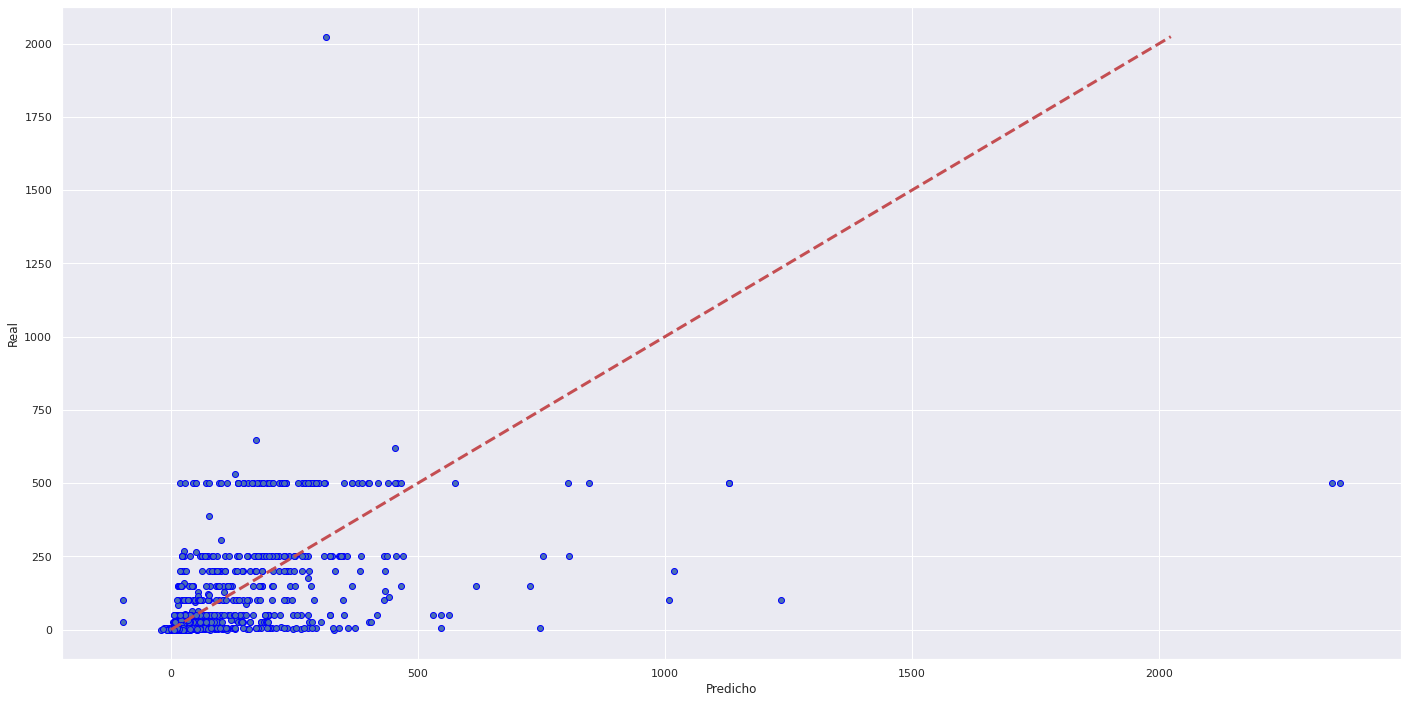

In [12]:
fig, ax = plt.subplots()
ax.scatter(test_probs, test_target, edgecolors=(0, 0, 1))
ax.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'r--', lw=3)
ax.set_xlabel('Predicho')
ax.set_ylabel('Real')
plt.show()

In [13]:
print("Performance del modelo")
print("--------------------------------------")
print('MAE {}'.format(mean_absolute_error(test_target, test_probs)))
print('MSE {}'.format(mean_squared_error(test_target, test_probs)))
print('RMSE {}'.format(mean_squared_error(test_target, test_probs, squared=False)))
print('R2 score {}'.format(r2_score(test_target, test_probs)))

Performance del modelo
--------------------------------------
MAE 44.38035357436453
MSE 14079.656915918034
RMSE 118.65773011446845
R2 score -0.08528045191305389


## Modelo de test con clasificación

In [14]:
target = pd.Series(np.where(target['target'] > 0, 1, 0), index=target.index)
print('distribución de clases: \n{}'.format(target.value_counts()))

distribución de clases: 
1    7361
0    2884
dtype: int64


## Separamos en train y test

In [15]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=TEST_SIZE,
                                                                    random_state=SEED, stratify=target)

In [16]:
fi = []
val_probs = []
test_probs = []
i = 0

for train_index, valid_index in StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=SEED).split(train_data,
                                                                                                        train_target):
    i += 1
    train_data_fold = train_data.iloc[train_index]
    train_target_fold = train_target.loc[train_data.index].iloc[train_index]

    val_data_fold = train_data.iloc[valid_index]
    val_target_fold = train_target.loc[train_data.index].iloc[valid_index]

    learner = LGBMClassifier(n_estimators=10000, random_state=SEED, objective='binary')
    learner.fit(train_data_fold, train_target_fold, early_stopping_rounds=50, eval_metric="auc",
                eval_set=[(train_data_fold, train_target_fold), (val_data_fold, val_target_fold)],
                verbose=50)

    val_probs.append(pd.Series(learner.predict_proba(val_data_fold)[:, -1], name="fold_" + str(i)))
    test_probs.append(pd.Series(learner.predict_proba(test_data)[:, -1], index=test_data.index,
                                name="fold_" + str(i)))
    fi.append(pd.Series(learner.feature_importances_ /
                        learner.feature_importances_.sum(), index=train_data_fold.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
fi = pd.concat(fi, axis=1).mean(axis=1).sort_values(ascending=False)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.996588	training's binary_logloss: 0.0753207	valid_1's auc: 0.982092	valid_1's binary_logloss: 0.144538
Early stopping, best iteration is:
[44]	training's auc: 0.995821	training's binary_logloss: 0.0820503	valid_1's auc: 0.9821	valid_1's binary_logloss: 0.14659
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.996148	training's binary_logloss: 0.0790959	valid_1's auc: 0.992452	valid_1's binary_logloss: 0.102016
[100]	training's auc: 0.999023	training's binary_logloss: 0.0490736	valid_1's auc: 0.992011	valid_1's binary_logloss: 0.103038
Early stopping, best iteration is:
[51]	training's auc: 0.996289	training's binary_logloss: 0.0780447	valid_1's auc: 0.992522	valid_1's binary_logloss: 0.101714
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.996582	training's binary_logloss: 0.0755718	valid_1's auc: 0.980248	valid_1's binary_logloss:

In [17]:
def find_optimal_cutoff(true_label, prediction):
    """Encuentra la probabilidad de corte óptima para un problema de clasificación binaria basandose en la curva ROC"""
    fpr, tpr, thresh = roc_curve(true_label, prediction)
    idx = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=idx), 'threshold': pd.Series(thresh, index=idx)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

print("Performance del modelo")
print("--------------------------------------")
# predicción del resultado
threshold = find_optimal_cutoff(test_target, test_probs)
pred_target = pd.Series(np.where(test_probs > threshold[0], 1, 0), index=test_probs.index)
conf_mat = pd.DataFrame(confusion_matrix(test_target, pred_target), columns=['0', '1'], index=['0', '1'])
print("\nProbabilidad de corte: {}".format(threshold[0]))
print("\nMatriz de Confusión (filas=real, columnas=prediccion)")
print(conf_mat)
print("\nReporte de Clasificación")
print(classification_report(test_target, pred_target, target_names=['0', '1']))
print("\nAccuracy_score: {}".format(accuracy_score(test_target, pred_target)))
print("\nROC_auc_score: {}\n".format(roc_auc_score(test_target, test_probs)))

Performance del modelo
--------------------------------------

Probabilidad de corte: 0.7706791597992443

Matriz de Confusión (filas=real, columnas=prediccion)
     0     1
0  554    23
1   62  1410

Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       577
           1       0.98      0.96      0.97      1472

    accuracy                           0.96      2049
   macro avg       0.94      0.96      0.95      2049
weighted avg       0.96      0.96      0.96      2049


Accuracy_score: 0.9585163494387506

ROC_auc_score: 0.9889061440358677



In [ ]:
# TODO graficar fi